# Tâche #1 : Prédiction du score NOVA d'aliments avec des modèles *Transformers*

# NOTEBOOK POUR BERT

In [1]:
#Pour gérer les fichiers depuis le drive sur Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Préparation des données

Notre objectif dans cette section est de **charger** les 3 splits, **valider le schéma**, **créer un mapping d’étiquettes stable** (texte → entiers 0..3), et **choisir un `max_length`** raisonnable pour la suite avec Transformers.

Nous respecterons les contraintes de l'énoncé :
- **Aucune normalisation** autre que **la mise en minuscules**.
- **Tokenisation** : celle des modèles Hugging Face.
- **Modèles** : Hugging Face uniquement.

Le travail se fera en 4 étapes :
1. **Vérification de l’environnement** (versions, GPU, seed) + **chargement** des fichiers train/dev/test.
2. **Analyse des labels** et création de la colonne **`labels`** (0..3) compatibles Hugging Face avec mappings sauvegardés.
3. **Mesure des longueurs** (caractères + **tokens BERT**) pour fixer `max_length` pour des soucis de performance.
4. **Vérification de l'hygiène des données** (vides, doublons, chevauchements) et décisions pour la suite du travail.

### 1.A. Vérification de l'environnement et chargement des données




In [2]:
# --- Vérif env + seed ---
import sys, torch, numpy as np, pandas as pd
import transformers, datasets
from transformers import set_seed
from platform import python_version

print("Python:", python_version())
print("Torch:", torch.__version__, "| CUDA dispo ?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Transformers:", transformers.__version__, "| Datasets:", datasets.__version__)

set_seed(42)
print("Seed fixée à 42.")

Python: 3.12.12
Torch: 2.8.0+cu126 | CUDA dispo ? True
GPU: Tesla T4
Transformers: 4.57.1 | Datasets: 4.0.0
Seed fixée à 42.


In [3]:
# --- Chargement + sanity checks ---
import os, json
from datasets import load_dataset
import pandas as pd
from collections import Counter

#Pour une exécution en local, décommentez les trois lignes suivantes
#train_json_fn = "./data/t1_nova_train.json"
#dev_json_fn   = "./data/t1_nova_dev.json"
#test_json_fn  = "./data/t1_nova_test.json"

#Pour une exécution sur le drive avec Google Colab :
train_json_fn = "./drive/MyDrive/Colab Notebooks/data/t1_nova_train.json"
dev_json_fn   = "./drive/MyDrive/Colab Notebooks/data/t1_nova_dev.json"
test_json_fn  = "./drive/MyDrive/Colab Notebooks/data/t1_nova_test.json"

# 1.A.1) Chargement en DatasetDict
ds = load_dataset("json", data_files={
    "train": train_json_fn,
    "validation": dev_json_fn,
    "test": test_json_fn,
})
print("\nRésumé splits:")
print(ds)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]


Résumé splits:
DatasetDict({
    train: Dataset({
        features: ['text', 'nova'],
        num_rows: 7651
    })
    validation: Dataset({
        features: ['text', 'nova'],
        num_rows: 851
    })
    test: Dataset({
        features: ['text', 'nova'],
        num_rows: 2126
    })
})


Nous avons 3 splits disponibles : **train=7 651**, **dev=851**, **test=2 126**.  

Le schéma des données est homogène : colonnes **`text`** et **`nova`** (toutes deux en `string`).  

Affichons quelques exemples de données.

In [4]:
# 1.A.2) Colonnes / types
print("\nFeatures (train):")
print(ds["train"].features)

# 1.A.3) Aperçu de 3 exemples (train)
print("\nExemples (train):")
for i in range(min(3, len(ds["train"]))):
    row = ds["train"][i]
    keys = list(row.keys())
    preview = {k: (str(row[k])[:140].replace("\n"," ")+"…"
                   if isinstance(row[k], str) and len(row[k])>140 else row[k]) for k in keys}
    print(f"- #{i} ->", preview)


Features (train):
{'text': Value('string'), 'nova': Value('string')}

Exemples (train):
- #0 -> {'text': 'Name: Pepsi Diet, Categories: beverages-and-beverages-preparations, beverages, carbonated-drinks, artificially-sweetened-beverages, Ingredie…', 'nova': 'Groupe 4'}
- #1 -> {'text': 'Name: Macaroni, Categories: plant-based-foods-and-beverages, plant-based-foods, pastas, Ingredients: durum semolina wheat , niacin,, ferrous…', 'nova': 'Groupe 1'}
- #2 -> {'text': 'Name: Passionfruit Guava Sparkling Soda, Categories: beverages, carbonated-drinks, sodas, Ingredients: carbonated water, invert cane sugar, …', 'nova': 'Groupe 4'}


C’est **exactement** ce qu’on attend pour créer ensuite les `labels` (0..3).

On voit aussi que `text` contient des informations riches (nom, catégories, **ingrédients**), très pertinentes pour prédire le **score NOVA** (produits ultra-transformés vs non transformés, etc.).

Ces champs devraient porter un **signal** utile pour le modèle.

### 1.B. Analyse et mapping des labels

In [5]:
# 1.B.1) Distribution des labels bruts
from collections import Counter

# Définition explicite des colonnes
TEXT_COL  = "text"
LABEL_COL = "nova"

# Vérifs de robustesse
assert TEXT_COL  in ds["train"].column_names, f"Colonne texte '{TEXT_COL}' introuvable"
assert LABEL_COL in ds["train"].column_names, f"Colonne label '{LABEL_COL}' introuvable"
print("OK -> TEXT_COL:", TEXT_COL, "| LABEL_COL:", LABEL_COL)

ytr = ds["train"][LABEL_COL]
ytr_str = [str(v) for v in ytr]
cnt = Counter(ytr_str)
print("\nRépartition des labels (train):")
for k in sorted(cnt.keys(), key=lambda x: (len(x), x)):
    print(f"  {k}: {cnt[k]}")

OK -> TEXT_COL: text | LABEL_COL: nova

Répartition des labels (train):
  Groupe 1: 804
  Groupe 2: 697
  Groupe 3: 1276
  Groupe 4: 4874


On remarque un **Déséquilibre marqué** des données du train vers *Groupe 4* : la baseline “**toujours G4**” est à **~0.637** d’accuracy.  Le groupe 2 est le moins représenté.

Par conséquent, on évaluera et sélectionnera le meilleur modèle principalement à la **macro-F1**, plus juste sur des classes minoritaires.

Procédons au mapping des labels.

In [6]:
# 1.B.2) Mapping des labels textuels vers des entiers
import re

# Construction d'un mapping stable à partir des valeurs de train
raw_train_labels = sorted(set(ds["train"]["nova"]),
                          key=lambda s: int(re.search(r"\d+", s).group()))
label2id = {name: (int(re.search(r"\d+", name).group()) - 1) for name in raw_train_labels}
id2label = {v: k for k, v in label2id.items()}
num_labels = len(label2id)

print("Mapping retenu:")
for k in sorted(label2id, key=lambda s: int(re.search(r"\d+", s).group())):
    print(f"  {k:>8} -> {label2id[k]}")

# Application du mapping et création de la colonne 'labels'
def map_labels(batch):
    return {"labels": [label2id[v] for v in batch["nova"]]}

ds = ds.map(map_labels, batched=True, desc="Ajout de la colonne 'labels' (0..3)")

Mapping retenu:
  Groupe 1 -> 0
  Groupe 2 -> 1
  Groupe 3 -> 2
  Groupe 4 -> 3


Ajout de la colonne 'labels' (0..3):   0%|          | 0/7651 [00:00<?, ? examples/s]

Ajout de la colonne 'labels' (0..3):   0%|          | 0/851 [00:00<?, ? examples/s]

Ajout de la colonne 'labels' (0..3):   0%|          | 0/2126 [00:00<?, ? examples/s]

In [7]:
# Répartition par split
def show_counts(split):
    cnt = Counter(ds[split]["labels"])
    ordered = [cnt.get(i, 0) for i in range(num_labels)]
    print(f"{split:>10} ->", ordered, "(index = classe id)")
    return ordered

print("\nRépartition par split (labels entiers):")
train_counts = show_counts("train")
dev_counts   = show_counts("validation")
test_counts  = show_counts("test")

# Baseline majoritaire
def _majority_id(labels, num_labels):
    cnt = Counter(labels)
    return max(range(num_labels), key=lambda i: cnt.get(i, 0))

def baseline_metrics_for_split(dataset, split, num_labels, id2label, maj_id=None):
    """Calcule acc et macro-F1 pour la baseline 'toujours maj' sur un split.
       Si maj_id est None, on prend la majorité de CE split.
       Sinon, on applique une majorité fixée (ex: majorité du train)."""
    y_true = np.array(dataset[split]["labels"])
    if maj_id is None:
        maj_id = _majority_id(y_true, num_labels)
    y_pred = np.full_like(y_true, maj_id)
    acc = accuracy_score(y_true, y_pred)
    mf1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    print(f"{split:>10} | baseline=always {id2label[maj_id]:<8} -> acc={acc:.3f} | macro-F1={mf1:.3f}")
    return acc, mf1, maj_id

# Sauvegarder les mappings

#En local :
#os.makedirs("./artifacts_bert", exist_ok=True)
#with open("./artifacts_bert/label2id.json","w") as f:
#    json.dump(label2id, f, indent=2, ensure_ascii=False)
#with open("./artifacts_bert/id2label.json","w") as f:
#    json.dump({str(k): v for k, v in id2label.items()}, f, indent=2, ensure_ascii=False)

#Sur Colab
os.makedirs("./drive/MyDrive/Colab Notebooks/artifacts_bert", exist_ok=True)
with open("./drive/MyDrive/Colab Notebooks/artifacts_bert/label2id.json","w") as f:
    json.dump(label2id, f, indent=2, ensure_ascii=False)
with open("./drive/MyDrive/Colab Notebooks/artifacts_bert/id2label.json","w") as f:
    json.dump({str(k): v for k, v in id2label.items()}, f, indent=2, ensure_ascii=False)

print("\nMappings écrits dans ./artifacts_bert/")


Répartition par split (labels entiers):
     train -> [804, 697, 1276, 4874] (index = classe id)
validation -> [89, 78, 142, 542] (index = classe id)
      test -> [223, 194, 355, 1354] (index = classe id)

Mappings écrits dans ./artifacts_bert/


In [8]:
from sklearn.metrics import accuracy_score, f1_score

def _majority_id(labels, num_labels):
    cnt = Counter(labels)
    return max(range(num_labels), key=lambda i: cnt.get(i, 0))

def baseline_metrics_for_split(dataset, split, num_labels, id2label, maj_id=None):
    y_true = np.array(dataset[split]["labels"])
    if maj_id is None:
        maj_id = _majority_id(y_true, num_labels)
    y_pred = np.full_like(y_true, maj_id)

    acc = accuracy_score(y_true, y_pred)
    mf1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    print(f"{split:>10} | baseline=always {id2label[maj_id]:<8} -> acc={acc:.3f} | macro-F1={mf1:.3f}")
    return acc, mf1, maj_id

print("\n=== Baseline par split (majorité propre à chaque split) ===")
baseline_metrics_for_split(ds, "train",      num_labels, id2label)
baseline_metrics_for_split(ds, "validation", num_labels, id2label)
baseline_metrics_for_split(ds, "test",       num_labels, id2label)

print("\n=== Baseline avec majorité du train appliquée à dev/test ===")
maj_train = _majority_id(ds["train"]["labels"], num_labels)
print("Classe majoritaire (train) =", id2label[maj_train])
baseline_metrics_for_split(ds, "train",      num_labels, id2label, maj_id=maj_train)
baseline_metrics_for_split(ds, "validation", num_labels, id2label, maj_id=maj_train)
baseline_metrics_for_split(ds, "test",       num_labels, id2label, maj_id=maj_train)


=== Baseline par split (majorité propre à chaque split) ===
     train | baseline=always Groupe 4 -> acc=0.637 | macro-F1=0.195
validation | baseline=always Groupe 4 -> acc=0.637 | macro-F1=0.195
      test | baseline=always Groupe 4 -> acc=0.637 | macro-F1=0.195

=== Baseline avec majorité du train appliquée à dev/test ===
Classe majoritaire (train) = Groupe 4
     train | baseline=always Groupe 4 -> acc=0.637 | macro-F1=0.195
validation | baseline=always Groupe 4 -> acc=0.637 | macro-F1=0.195
      test | baseline=always Groupe 4 -> acc=0.637 | macro-F1=0.195


(0.6368767638758231, 0.19454022988505748, 3)

La **même tendance** (G4 majoritaire) se retrouve en dev/test : c’est sain pour valider la généralisation.

Accuracy de baseline = proportion d’exemples du split appartenant à la classe majoritaire (G4) = 0.64

Macro-F1 de baseline = F1 moyen sur les 4 classes quand on prédit toujours la même classe (valeur typiquement faible, ~0.19)


Analysons la longueur des textes pour définir max_lengths.

### 1.C. Analyse des longueurs de texte

In [9]:
# 1.C.1) Longueurs en caractères
import numpy as np
import matplotlib.pyplot as plt

def lengths_char(examples):
    xs = examples["text"]
    return {"len_char": [len(x) if isinstance(x, str) else 0 for x in xs]}

tmp = ds.map(lengths_char, batched=True, desc="Compute char lengths")

def show_stats(split):
    L = np.array(tmp[split]["len_char"])
    n = L.size
    print(f"{split}: n={n} | median={np.median(L):.0f} | p90={np.percentile(L,90):.0f} | "
          f"p95={np.percentile(L,95):.0f} | max={L.max()}")
    for th in (64, 128, 256, 512):
        pct = (L > th).mean()*100
        print(f"  > {th} chars : {pct:5.1f}%")

show_stats("train")
show_stats("validation")
show_stats("test")

Compute char lengths:   0%|          | 0/7651 [00:00<?, ? examples/s]

Compute char lengths:   0%|          | 0/851 [00:00<?, ? examples/s]

Compute char lengths:   0%|          | 0/2126 [00:00<?, ? examples/s]

train: n=7651 | median=418 | p90=779 | p95=946 | max=4566
  > 64 chars :  99.9%
  > 128 chars :  98.9%
  > 256 chars :  86.3%
  > 512 chars :  33.8%
validation: n=851 | median=420 | p90=709 | p95=880 | max=2133
  > 64 chars :  99.8%
  > 128 chars :  98.6%
  > 256 chars :  85.7%
  > 512 chars :  33.0%
test: n=2126 | median=422 | p90=789 | p95=966 | max=2729
  > 64 chars :  99.9%
  > 128 chars :  99.1%
  > 256 chars :  85.4%
  > 512 chars :  33.6%


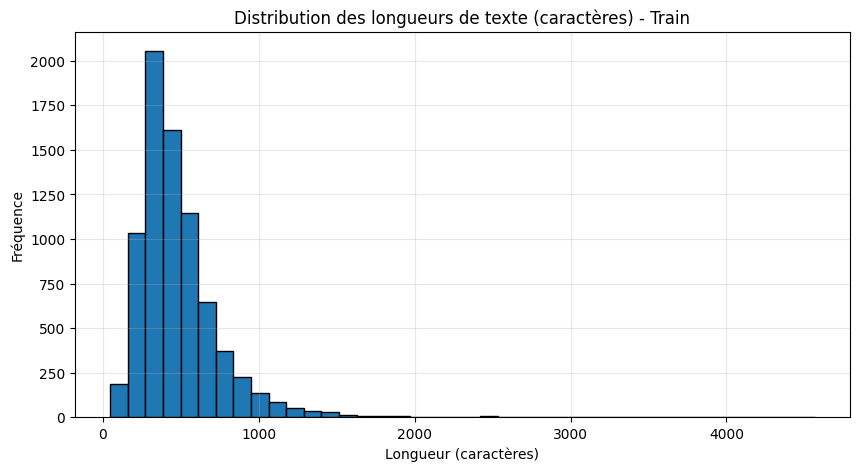

In [10]:
# Histogramme des longueurs (pour train)
L_train = np.array(tmp["train"]["len_char"])
plt.figure(figsize=(10, 5))
plt.hist(L_train, bins=40, edgecolor='black')
plt.title("Distribution des longueurs de texte (caractères) - Train")
plt.xlabel("Longueur (caractères)")
plt.ylabel("Fréquence")
plt.grid(alpha=0.3)
plt.show()

~**33 %** des textes > **512** chars :
on comprend que les descriptions sont **longues**, mais la **tokenisation** (en **tokens**) est la vraie référence pour fixer `max_length`.

In [ ]:
# 1.C.2) Longueurs en tokens BERT
from transformers import AutoTokenizer

tok_bert = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

def token_lens(batch):
    enc = tok_bert(batch["text"], add_special_tokens=True, truncation=False)
    return {"len_tok": [len(x) for x in enc["input_ids"]]}

tok_ds = ds.map(token_lens, batched=True, desc="Compute BERT token lengths")

def show_tok_stats(split):
    L = np.array(tok_ds[split]["len_tok"])
    print(f"{split}: n={L.size} | median={np.median(L):.0f} | p90={np.percentile(L,90):.0f} | "
          f"p95={np.percentile(L,95):.0f} | p99={np.percentile(L,99):.0f} | max={L.max()}")
    for th in (64, 128, 256, 384, 512):
        pct = (L > th).mean()*100
        print(f"  > {th:>3} tokens : {pct:5.1f}%")
    return L

Ltr = show_tok_stats("train")
Ldv = show_tok_stats("validation")
Lte = show_tok_stats("test")

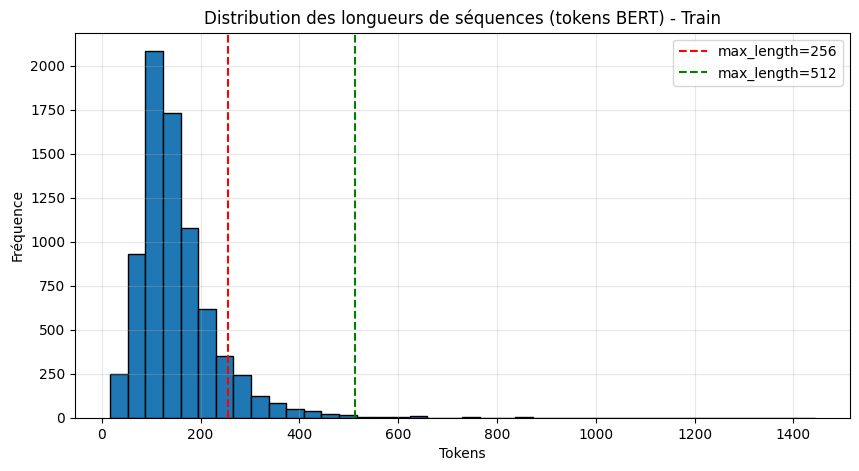

In [12]:
# Histogramme des tokens BERT
plt.figure(figsize=(10, 5))
plt.hist(Ltr, bins=40, edgecolor='black')
plt.title("Distribution des longueurs de séquences (tokens BERT) - Train")
plt.xlabel("Tokens")
plt.ylabel("Fréquence")
plt.axvline(x=256, color='r', linestyle='--', label='max_length=256')
plt.axvline(x=512, color='g', linestyle='--', label='max_length=512')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Pour les **Longueurs (tokens BERT, sans troncature) :**  
- **Médiane ≈ 134**, P90 ≈ 249, P95 ≈ 299, P99 ≈ 432.  
- **>128 tokens ~53 %** → `max_length=128` **tronquerait ~1 texte sur 2**.  
- **>256 tokens ~6–9 %** → `max_length=256` couvre **~91–94 %** des cas --> La troncature serait suffisante pour capturer la majorité du contenu.
- **>512 tokens ~0.4–0.6 %** (BERT hard limit 512) --> les limites de Bert permettraient d'exploiter pleinement notre corpus

Donc on peut travailler sans troncature **`max_length=512`** (padding dynamique) pour **préserver l’info**
(*Si besoin d’accélérer un run exploratoire, `max_length=256` est un bon compromis ; on le mentionnera si on l’utilise.*)

On vérifie maintenant que nos données sont "propres" avant de passer à BERT.




### 1.D. Hygiène des données

In [13]:
# Vérification des textes vides et des doublons
def is_empty(s):
    return (s is None) or (not isinstance(s, str)) or (len(s.strip()) == 0)

def count_empties(split):
    xs = ds[split]["text"]
    return sum(is_empty(x) for x in xs), len(xs)

def count_dups_intra(split):
    xs = ds[split]["text"]
    return len(xs) - len(set(xs))

def count_dups_inter(a, b):
    A, B = set(ds[a]["text"]), set(ds[b]["text"])
    return len(A & B)

print("Vérification de l'hygiène des données:\n")
for sp in ["train","validation","test"]:
    e, n = count_empties(sp)
    print(f"{sp:>10} | vides : {e:3d} / {n:4d} | doublons intra : {count_dups_intra(sp):3d}")

print("\nChevauchements inter-splits:")
print(f"  train ∩ dev  : {count_dups_inter('train','validation')}")
print(f"  train ∩ test : {count_dups_inter('train','test')}")
print(f"  dev   ∩ test : {count_dups_inter('validation','test')}")

Vérification de l'hygiène des données:

     train | vides :   0 / 7651 | doublons intra : 100
validation | vides :   0 /  851 | doublons intra :   3
      test | vides :   0 / 2126 | doublons intra :  13

Chevauchements inter-splits:
  train ∩ dev  : 13
  train ∩ test : 40
  dev   ∩ test : 7


Aucun texte vide, quelques doublons intra-split (train **100**, dev **3**, test **13**) et quelques chevauchements inter-splits : train∩dev **13**, train∩test **40**, dev∩test **7** : on **garde le dataset tel quel** (fidélité aux splits fournis) et on **mentionnera** dans l’analyse que quelques textes identiques existent entre splits ; l’évaluation reste valable puisqu’on n’entraîne/valide/teste **que** sur les splits définis.

### Bilan de la préparation des données

On a
- Chargé 3 splits: train (7 651), dev (851), test (2 126)
- Créé le mapping: Groupe 1→0, Groupe 2→1, Groupe 3→2, Groupe 4→3
- Ajouté la Colonne `labels` et sauvegardé les mappings

Pour les train, les classes sont telles que :
- Distribution: [804, 697, 1276, 4874]
- Groupe 4 domine (~64% des exemples)
- Baseline "classe majoritaire": 0.637
- **Déséquilibre important** → on privilégiera le **macro-F1** pour l'évaluation

Concernant les longueurs des textes :
- Médiane: ~134 tokens BERT
- P90: ~249 tokens, P95: ~299 tokens
- Très peu de textes > 512 tokens
- Donc on choisira `max_length=512`** (couvre quasiment tous les cas).

**Hygiène des données :**
- Aucun texte vides
- Quelques doublons intra/inter-splits (on garde tel quel)


Nous allons maintenant procéder au Fine-tuning de **bert-base-uncased** et au Fine-tuning d'un modèle **multilingue** (xlm-roberta-base, dans un autre notebook), puis comparer et analyser les résultats

---

## 2. Modèle 1: BERT (bert-base-uncased)

### 2.1 Configuration et tokenisation

## 2.1 — Configuration et tokenisation (BERT)

Il s'agit ici de
1) charger le **tokenizer** BERT (uncased),  
2) fixer un **`max_length=512`** (pas de troncature puisque c'est possible avec BERT et cela tombe bien vu que cela ne tronque pas nos données d'après l'analyse exploratoire),  
3) **tokeniser** les 3 splits en conservant `labels`,  
4) activer un **padding dynamique** via `DataCollatorWithPadding`,  
5) faire un petit **sanity check** (exemple décodé / longueurs).

On ne fait **aucune normalisation** additionnelle (BERT *uncased* gère déjà les minuscules) et **Tokenisation HF** uniquement.  

On gardera **les mêmes choix** pour le modèle multilingue afin de comparer proprement.

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

# Nom du modèle
MODEL_BERT = "bert-base-uncased"
MAX_LENGTH = 512

# Charger le tokenizer
tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_BERT, use_fast=True)
print(f"Tokenizer chargé: {MODEL_BERT}")
print(f"Vocabulaire: {len(tokenizer_bert)} tokens")

Tokenizer chargé: bert-base-uncased
Vocabulaire: 30522 tokens


In [15]:
# Fonction de tokenisation
def tokenize_function_bert(examples):
    """Tokenise les textes avec troncature à max_length."""
    return tokenizer_bert(
        examples[TEXT_COL],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False  # On fera du padding dynamique avec DataCollator
    )

# Appliquer la tokenisation
tokenized_ds_bert = ds.map(
    tokenize_function_bert,
    batched=True,
    desc="Tokenisation BERT",
    remove_columns=[TEXT_COL, LABEL_COL]  # On garde uniquement input_ids, attention_mask, labels
)

print("\nExemple tokenisé (train[0]):")
print(tokenized_ds_bert["train"][0])

Tokenisation BERT:   0%|          | 0/7651 [00:00<?, ? examples/s]

Tokenisation BERT:   0%|          | 0/851 [00:00<?, ? examples/s]

Tokenisation BERT:   0%|          | 0/2126 [00:00<?, ? examples/s]


Exemple tokenisé (train[0]):
{'labels': 3, 'input_ids': [101, 2171, 1024, 27237, 8738, 1010, 7236, 1024, 21705, 1011, 1998, 1011, 21705, 1011, 12929, 1010, 21705, 1010, 26427, 2094, 1011, 8974, 1010, 7976, 2135, 1011, 4086, 6675, 1011, 21705, 1010, 12760, 1024, 26427, 2094, 2300, 1010, 14418, 10199, 6120, 1010, 6887, 2891, 8458, 29180, 5648, 1010, 2004, 19362, 15464, 2063, 13412, 11460, 26271, 1010, 3397, 6887, 2368, 23943, 21141, 2638, 1010, 13365, 17770, 16503, 2063, 1010, 24689, 7959, 3170, 1010, 3019, 28126, 1010, 20232, 21007, 14074, 18044, 3590, 11460, 26271, 19875, 1010, 25022, 12412, 5648, 1010, 8214, 16921, 14277, 20872, 22360, 18684, 2638, 12760, 1024, 19413, 2226, 3657, 10128, 2666, 2063, 1010, 3609, 4630, 14418, 10199, 1010, 5648, 2063, 6887, 2891, 8458, 10050, 4226, 1010, 2004, 19362, 15464, 2063, 13412, 19481, 2629, 9530, 9515, 3372, 2139, 2474, 6887, 2368, 23943, 21141, 2638, 1010, 17770, 16503, 2063, 2139, 13365, 1010, 7668, 2638, 4748, 8462, 3267, 2140, 1010, 20232, 2

In [16]:
# Data collator pour le padding dynamique
data_collator_bert = DataCollatorWithPadding(tokenizer=tokenizer_bert)
print("Data collator créé (padding dynamique)")

Data collator créé (padding dynamique)


**La tokenisation est terminée sur les 3 splits.**  
- Le dataset contient maintenant `input_ids`, `attention_mask`, `token_type_ids` + `labels`.  
- Pour une séquence simple (classification d’un seul texte), **`token_type_ids`** sont des zéros (normal pour BERT).  
- L’exemple de `train[0]` montre une **séquence bien formée** (`[CLS] … [SEP]`) et le **label=3** (Groupe 4), cohérent avec notre mapping.

### 2.2 Métriques d'évaluation

Le jeu étant fortement **déséquilibré** (Groupe 4 ≈ 64 %), une simple accuracy peut masquer des erreurs sur les classes minoritaires.  On utilisera : 
- **Accuracy** : repère global (à comparer à la baseline “toujours G4” ≈ **0.637**).  
- **Macro-F1** : moyenne des F1 par classe **sans pondération** met chaque classe à poids égal. C’est **la métrique principale** pour sélectionner le meilleur checkpoint.


In [17]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

def compute_metrics(eval_pred):
    """Calcule accuracy et macro-F1."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
    }

print("Fonction compute_metrics définie")

Fonction compute_metrics définie


La fonction `compute_metrics` sera appelée à chaque évaluation (fin d’époque ou tous les *eval_steps*). Ici on calcule **accuracy** et **macro-F1** ; on configurera `metric_for_best_model="f1_macro"` avec `load_best_model_at_end=True`.

### 2.3 Configuration de l'entraînement





In [18]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

# Charger le modèle pré-entraîné avec la tête de classification
model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODEL_BERT,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

print(f"Modèle BERT chargé avec {num_labels} classes")
print(f"Nombre de paramètres: {model_bert.num_parameters():,}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle BERT chargé avec 4 classes
Nombre de paramètres: 109,485,316


Le warning sur `classifier.*` est attendu : la tête de classification (4 classes) est **réinitialisée** et sera entraînée sur notre tâche NOVA. Le corps BERT est bien chargé depuis `bert-base-uncased`.

In [19]:
# Arguments d'entraînement
training_args_bert = TrainingArguments(

    #En local
    #output_dir="./results_bert",

    #Sur drive
    output_dir="./drive/MyDrive/Colab Notebooks/results_bert",

    # Stratégie d'évaluation et de sauvegarde
    eval_strategy="epoch",
    save_strategy="epoch",

    # Hyperparamètres
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,

    # Logging
    logging_dir="./logs_bert",
    logging_strategy="steps",
    logging_steps=50,

    # Sauvegarde et early stopping
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",  # On optimise sur le macro-F1
    greater_is_better=True,
    save_total_limit=2,  # Garde seulement les 2 meilleurs checkpoints

    # Seed et performance
    seed=42,
    fp16=True,

    # Désactive les warnings inutiles
    report_to="none",  # Pas de WandB

    group_by_length=True,
    dataloader_pin_memory=True,
)

print("TrainingArguments configurés:")
print(f"  - Batch size (train): {training_args_bert.per_device_train_batch_size}")
print(f"  - Learning rate: {training_args_bert.learning_rate}")
print(f"  - Epochs: {training_args_bert.num_train_epochs}")
print(f"  - Métrique d'optimisation: {training_args_bert.metric_for_best_model}")

TrainingArguments configurés:
  - Batch size (train): 16
  - Learning rate: 2e-05
  - Epochs: 5
  - Métrique d'optimisation: f1_macro


- On évalue **à chaque époque** (`eval_strategy="epoch"`) pour alimenter l’early-stopping et sélectionner le **meilleur checkpoint** sur `f1_macro`.  
- `fp16=True` (T4) pour accélérer, `save_total_limit=2` pour limiter l’IO.  
- `per_device_eval_batch_size` ajusté à **16** pour éviter un OOM.  
- `group_by_length=True` pour regrouper des séquences de tailles proches -> **moins de padding** global, débit plus stable.

In [20]:
# Création du Trainer avec early stopping
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=tokenized_ds_bert["train"],
    eval_dataset=tokenized_ds_bert["validation"],
    tokenizer=tokenizer_bert,
    data_collator=data_collator_bert,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3,
            early_stopping_threshold=0.001
        )
    ]
)

print("Trainer BERT créé avec early stopping (patience=3)")

Trainer BERT créé avec early stopping (patience=3)


/tmp/ipython-input-3685637397.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


Early stopping : patience=3 → si le **macro-F1** n’améliore plus pendant 3 époques consécutives (avec `evaluation_strategy="epoch"`), l’entraînement s’arrête et on recharge le **meilleur** checkpoint (suivant `metric_for_best_model="f1_macro"`).

### 2.4 Entraînement du modèle BERT

**Note:** L'entraînement peut prendre plusieurs minutes selon le matériel disponible.
Avec GPU sur Google Colab, compter environ 10 minutes. Sans GPU, et malgré des optimisations (réduction de max_length et per_device_train_batch_size), nous n'avons pas réussi à faire tourner le programme en temps raisonnable sur des MacBook M1.

In [21]:
# Lancement de l'entraînement
print("Début de l'entraînement BERT...\n")
train_result_bert = trainer_bert.train()
print("\nEntraînement BERT terminé!")

Début de l'entraînement BERT...



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.484100,0.383917,0.828437,0.587894
2,0.240100,0.223311,0.935370,0.912261
3,0.158900,0.231231,0.945946,0.923751
4,0.092700,0.239203,0.950646,0.935655
5,0.036000,0.247908,0.954172,0.939017



Entraînement BERT terminé!


In [22]:
# Affichage des métriques d'entraînement
print("\nMétriques d'entraînement:")
for key, value in train_result_bert.metrics.items():
    print(f"  {key}: {value:.4f}")


Métriques d'entraînement:
  train_runtime: 480.7608
  train_samples_per_second: 79.5720
  train_steps_per_second: 4.9820
  total_flos: 3083653219372128.0000
  train_loss: 0.2414
  epoch: 5.0000


Après l'entrainement,   

- F1-macro : 0.588 → 0.912 → 0.924 → 0.936 → 0.939 (É1→É5).
      
- Accuracy : 0.828 → 0.935 → 0.946 → 0.951 → 0.954.
	
- Validation loss — minimum à É2 = 0.2233, puis remontée (É3 : 0.2312 → É4 : 0.2392 → É5 : 0.2479) tandis que la training-loss décroît (0.484 → 0.036). Cela indique un sur-apprentissage léger dès É2, mais non pénalisant pour la métrique cible puisque la F1-macro continue de progresser jusqu’à É5.
	
- Checkpoint retenu — avec load_best_model_at_end=True et metric_for_best_model="f1_macro", le meilleur modèle est É5 (F1-macro = 0.9390 sur dev).

- Par rapport à la baseline « classe majoritaire » (acc ≈ 0.637, F1-macro ≈ 0.195), le gain est très important, montrant une bien meilleure prise en compte des classes minoritaires.

Remarque :  La hausse de val_loss après É2, combinée à la baisse continue de train_loss, traduit un sur-apprentissage modéré mais la généralisation reste excellente et continue de s’améliorer jusqu’à la dernière époque.

### 2.5 Évaluation sur le set de test

In [23]:
# Évaluation sur le test set
print(" Évaluation sur le set de test...\n")
trainer_bert.args.group_by_length = False # Désactive le bucketing par longueur pendant éval/prédiction
                                          # pour conserver conserve EXACTEMENT l'ordre du dataset (même ordre que ds["test"]),
                                          # ce qui facilite l'alignement texte/label/pred par index et permet de comparer facilement ds["test"][i] avec y_true[i] / y_pred[i];
                                          # True accélère (moins de padding) mais peut regrouper par longueur et donc changer l’ordre de parcours
                                          # ce qui pose des problèmes si on veut analyser les texts bien classés ou mal classés
                                          # Contrepartie : un peu plus de padding -> éval/predict légèrement plus lentes.
pred = trainer_bert.predict(tokenized_ds_bert["test"])

# Métriques (issues de compute_metrics) – attention au préfixe "test_"
print(" Résultats sur le test set (BERT):")
print(f"  Accuracy: {pred.metrics['test_accuracy']:.4f}")
print(f"  Macro-F1: {pred.metrics['test_f1_macro']:.4f}")
print(f"  Loss:     {pred.metrics['test_loss']:.4f}")

 Évaluation sur le set de test...



 Résultats sur le test set (BERT):
  Accuracy: 0.9647
  Macro-F1: 0.9551
  Loss:     0.1813


In [24]:
# Prédictions sur le test set pour analyse détaillée
y_true = pred.label_ids
y_pred = pred.predictions.argmax(-1)

from sklearn.metrics import classification_report, confusion_matrix
print("\n Rapport de classification détaillé (BERT):\n")
print(classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(num_labels)],
    digits=4
))




 Rapport de classification détaillé (BERT):

              precision    recall  f1-score   support

    Groupe 1     0.9327    0.9327    0.9327       223
    Groupe 2     0.9948    0.9845    0.9896       194
    Groupe 3     0.9308    0.9099    0.9202       355
    Groupe 4     0.9743    0.9815    0.9779      1354

    accuracy                         0.9647      2126
   macro avg     0.9582    0.9522    0.9551      2126
weighted avg     0.9646    0.9647    0.9646      2126



Accuracy = 0.9647, Macro-F1 = 0.9551 → gain massif vs baseline (acc 0.637, F1-macro ≈0.195).

Par classe (F1) : 
- G2 = 0.9896 (quasi parfait), 
- G4 = 0.9779 (classe majoritaire très bien maîtrisée), 
- G1 = 0.9327, G3 = 0.9202 (les plus difficiles).

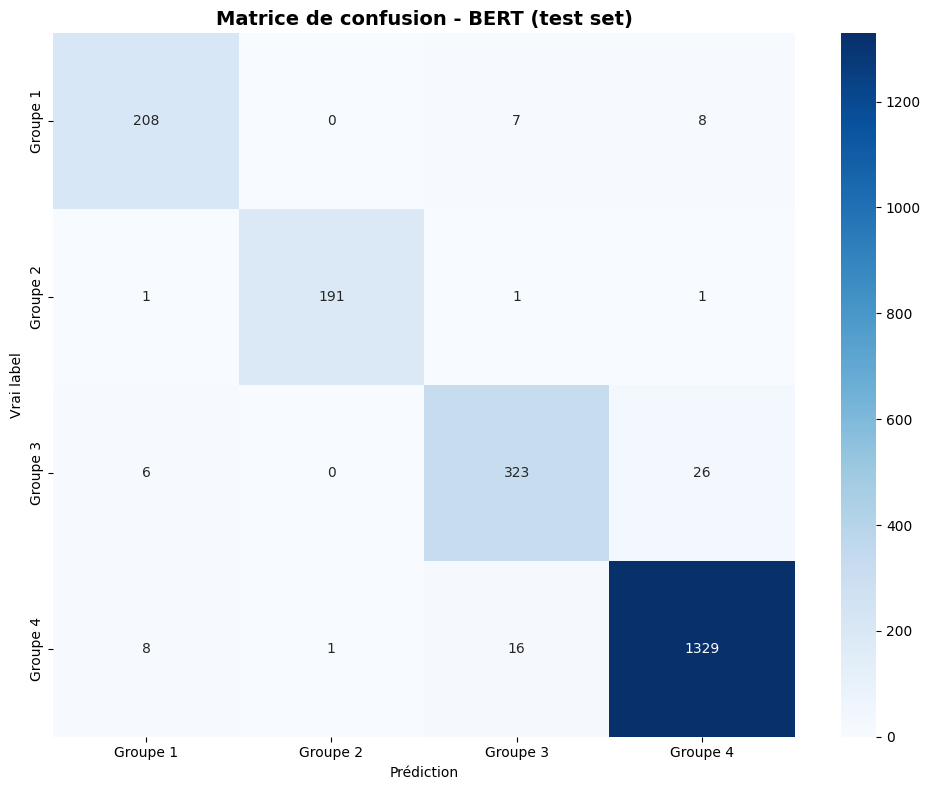

Matrice de confusion sauvegardée dans ./artifacts_bert/


In [25]:
# Matrice de confusion
import seaborn as sns

cm_bert = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)]
)
plt.title('Matrice de confusion - BERT (test set)', fontsize=14, fontweight='bold')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.tight_layout()
plt.show()

# Sauvegarde de la matrice
#En local :
#np.save('./artifacts_bert/confusion_matrix_bert.npy', cm_bert)
#Sur le drive :
np.save('./drive/MyDrive/Colab Notebooks/artifacts_bert/confusion_matrix_bert.npy', cm_bert)
print("Matrice de confusion sauvegardée dans ./artifacts_bert/")

Confusions principales : le gros du résiduel est le couple G3 <-> G4
- G3->G4 = 26 et G4->G3 = 16 (frontière “transformé” vs “ultra-transformé”).

Confusions secondaires (impliquant G1) :
- G1->G4 = 8, G1->G3 = 7, G3->G1 = 6, G4→G1 = 8.
- G2 est quasi parfait : 191/194 au bon endroit (seulement 3 erreurs : 1 vers chaque autre classe).

Cohérence dev <-> test : l’accuracy test est 0.9647 (2051/2126) et la macro-F1 = 0.9551 est du même ordre que sur dev ; pas de sur-ajustement manifeste. La val_loss remonte un peu après E2, mais la macro-F1 continue de progresser, donc E5 reste un choix défendable (sélection sur f1_macro).

**Note sur les doublons inter-splits :** il existe bien 40 textes communs train∩test. Cela peut légèrement optimiser les scores, mais nous respectons les splits fournis et appliquons la même procédure à tous les modèles, donc l’impact sur la comparaison reste négligeable.

### 2.6 Analyse d'erreurs (BERT)

In [26]:
# Récupération des textes originaux du test set
test_texts = ds["test"][TEXT_COL]

# Création d'un DataFrame avec les résultats
results_df_bert = pd.DataFrame({
    'text': test_texts,
    'true_label': y_true,
    'pred_label': y_pred,
    'true_name': [id2label[i] for i in y_true],
    'pred_name': [id2label[i] for i in y_pred],
    'correct': y_true == y_pred
})

# Statistiques globales
print(" Statistiques globales (BERT):")
print(f"  Total d'exemples: {len(results_df_bert)}")
print(f"  Prédictions correctes: {results_df_bert['correct'].sum()} ({results_df_bert['correct'].mean()*100:.2f}%)")
print(f"  Erreurs: {(~results_df_bert['correct']).sum()} ({(~results_df_bert['correct']).mean()*100:.2f}%)")

 Statistiques globales (BERT):
  Total d'exemples: 2126
  Prédictions correctes: 2051 (96.47%)
  Erreurs: 75 (3.53%)


In [27]:
# Analyse des erreurs par type de confusion
errors_bert = results_df_bert[~results_df_bert['correct']]

print("\n Analyse des erreurs par type de confusion (BERT):\n")
error_counts = errors_bert.groupby(['true_name', 'pred_name']).size().sort_values(ascending=False)
print(error_counts.head(12))


 Analyse des erreurs par type de confusion (BERT):

true_name  pred_name
Groupe 3   Groupe 4     26
Groupe 4   Groupe 3     16
           Groupe 1      8
Groupe 1   Groupe 4      8
           Groupe 3      7
Groupe 3   Groupe 1      6
Groupe 2   Groupe 4      1
           Groupe 3      1
           Groupe 1      1
Groupe 4   Groupe 2      1
dtype: int64


- G3 -> G4 = 26 et G4 -> G3 = 16 => 42/75 = 56 % des erreurs
=> C’est bien la frontière la plus dure (transformé vs ultra-transformé).

- G1 -> (G3/G4) = 7 + 8 = 15 -> 15/75 = 20 % des erreurs
=> Certains produits très simples (épices, beurres, vinaigres…) sont parfois assimilés à des produits plus transformés.

- Vers G1 depuis G3/G4 : 6 + 8 = 14 -> 18.7 % des erreurs.
=> Cas limites où la liste d’ingrédients ou la formulation “nature” tire la prédiction vers G1.

- Erreurs restantes (rares) : G2→(4/3/1) = 1+1+1 et G4→2 = 1 → 4/75 = 5.3 %.

- G2 quasi parfait : seulement 3 confusions (1 vers chaque autre classe).

In [31]:
# Exemples d'erreurs les plus fréquentes
print("\n Exemples d'erreurs courantes (BERT):\n")

for true_label, pred_label in error_counts.head(3).index:
    print(f"\n{'='*80}")
    print(f"Confusion: {true_label} → {pred_label}")
    print(f"{'='*80}")

    subset = errors_bert[
        (errors_bert['true_name'] == true_label) &
        (errors_bert['pred_name'] == pred_label)
    ]

    # Afficher 2 exemples
    for idx, row in subset.head(2).iterrows():
        text_preview = row['text'][:200] + "..." if len(row['text']) > 200 else row['text']
        print(f"\n  Texte: {text_preview}")
        print(f"  Vrai: {row['true_name']} | Prédit: {row['pred_name']}")


 Exemples d'erreurs courantes (BERT):


Confusion: Groupe 3 → Groupe 4

  Texte: Name: club Miche blanche, Categories: plant-based-foods-and-beverages, plant-based-foods, cereals-and-potatoes, breads, Ingredients: ingredients farine de ble enrichie, farine de blé intégrale, levure...
  Vrai: Groupe 3 | Prédit: Groupe 4

  Texte: Name: Omegamazing Bread, Categories: plant-based-foods-and-beverages, plant-based-foods, cereals-and-potatoes, breads, Ingredients: organic sprouted grains whole grain wheat, whole grain oats , water,...
  Vrai: Groupe 3 | Prédit: Groupe 4

Confusion: Groupe 4 → Groupe 3

  Texte: Name: Matcha Energy Drink, Categories: beverages, energy-drinks, Ingredients: ingredients sparkling water, organic cane sugar, organic lemon juice concentrate, organic flavours, monk fruit juice conce...
  Vrai: Groupe 4 | Prédit: Groupe 3

  Texte: Name: Original cranberry cocktail, Categories: beverages, Ingredients: filtered water, reconstituted cranberry juice, sugar, ascorbic ac

Groupe 3 -> Groupe 4
(ex. (pains) club Miche blanche, Omegamazing Bread)
- Les pains déclenchent souvent des indices “procédés” : mention « enriched / farine de blé enrichie », levure, sucres/huile ajoutés ou, plus généralement, la corrélation de catégorie (breads) historiquement proche de G4. Même quand la liste reste “grains + eau + levure” (profil G3), ces marqueurs et la sémantique de bread suffisent à sur-classer en G4.

Groupe 4 → Groupe 3 
(ex. (boissons sucrées) – Matcha Energy Drink, Original cranberry cocktail (EN).)
- Listes courtes avec lexique “positif” (organic cane sugar, sparkling water, organic flavours) et formes concentrées/édulcorées en fin de chaîne. Ce signal de simplicité sur-pondéré conduit à un downgrade en G3 malgré la présence de sucres/concentrés (gold G4).

Groupe 4 → Groupe 1
(ex. (eaux aromatisées / fruits) – Blueberry Pomegranate Sparkling Water Beverage, Pears General.)
- Listes minimalistes (eau gazéifiée, essence naturelle ; red pear seul) poussant vers G1. Sur ce corpus, certaines boissons “eau + arôme” ou fruits conditionnés portent un gold G4 (probable codage de famille “sodas”/produits préparés), d’où ces basculements G4→G1 quand le texte ne reflète pas clairement la transformation.

En bref. Le noyau d’erreurs reste la frontière G3↔G4 (transformé vs ultra-transformé), où pèsent fort : enriched, marqueurs de procédé (levure, sucres/huiles ajoutés, additifs quand présents), et mots de catégorie (bread, beverage). À l’inverse, des listes très courtes ou un lexique “organic/clean” peuvent tirer vers G3 voire G1.

Remarque – dans d’autres runs observés :
- G1→G4 sur boissons végétales “unsweetened” ou beurres/cubes bouillon (indices modified, épaississants, antioxydants précoces).
- G3↔G4 inversés sur confiseries/céréales (gums, modified starch/oils, flavours) ou, plus rarement, G3→G1 quand l’entête liste surtout des ingrédients “de base”.
- Original cranberry cocktail apparaît dans le corpus avec deux variantes d'ingrédients (en anglais :  G4, en français :  G1) et il arrive que Bert se trompe sur l'un, l'autre ou les deux, illustrant la sensibilité à la formulation exacte de l’étiquette.

Ces variations restent localisées et touchent des cas borderline où de faibles changements (ordre des indices, troncature nulle ici, stochasticité d’entraînement) suffisent à faire basculer la prédiction.

In [29]:
# Sauvegarde des résultats

#En local
#results_df_bert.to_csv('./artifacts_bert/predictions_bert_test.csv', index=False)
#Sur le drive
results_df_bert.to_csv('./drive/MyDrive/Colab Notebooks/artifacts_bert/predictions_bert_test.csv', index=False)

print("\nRésultats sauvegardés dans ./artifacts_bert/predictions_bert_test.csv")


Résultats sauvegardés dans ./artifacts_bert/predictions_bert_test.csv


### Conclusion pour le modèle BERT

Avec les hyperparamètres retenus (max_length = 512, batch = 16, LR = 2e-5, sélection sur F1-macro), BERT-uncased offre un comportement régulier et performant sur ce corpus majoritairement anglophone. Sur dev, la F1-macro culmine à 0,936 (É4) tandis que la val_loss atteint son minimum à É2 puis remonte légèrement, signe d’un sur-apprentissage modéré mais maîtrisé. Sur test, les scores se stabilisent à Accuracy = 0,9647 et F1-macro = 0,9551, nettement au-dessus de la baseline majoritaire (acc ≈ 0,637 ; F1-macro ≈ 0,195). Par classe, les performances sont élevées et homogènes (G2 = 0,9896, G4 = 0,9779, G1 = 0,9327, G3 = 0,9202 en F1), et le résiduel d’erreurs se concentre surtout sur la frontière G3↔G4 (26→ et 16←, soit 56 % des 75 erreurs), loin devant les confusions impliquant G1. L’insensibilité à la casse et le vocabulaire anglais appris massivement par BERT-uncased conviennent bien aux listes d’ingrédients et intitulés produits du jeu de données ; le plafond observé tient principalement à des cas borderline NOVA et à la sémantique des catégories plutôt qu’à une limite de capacité du modèle. En pratique, BERT-uncased constitue ici une référence robuste pour la tâche NOVA.